<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_all_mpnet_base_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data and SBERT (all-mpnet-base-v2)

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.


###Installing dependencies

In [1]:
# SBERT
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.2 MB/s 
     |████████████████████████████████| 4.0 MB 24.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 31.8 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 880 kB 42.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d1479906e58df1d678542745c2cc46b190d7b4cdd70c9e3dce361293b2c4f743
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e8fb4de7205825926610e4c4e03f634a769fe265f1f10dfb3224eb7f5eff9652
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

###Loading dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


In [3]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}fact_extraction_AILA/train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}fact_extraction_AILA/test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

rm: cannot remove 'data': No such file or directory


In [4]:
import pandas as pd
from os import listdir

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


###Features

In [5]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
import numpy as np

# Train features
train_features = None
train_targets = []
docs_train_features = {} # key: file id, value: numpy matrix of features
for doc_id, df in docs_train.items():
  features = sent_encoder.encode(df['sentence'].to_list())
  docs_train_features[doc_id] = features
  if train_features is None:
    train_features = features
  else:
    train_features = np.vstack((train_features, features))
  train_targets.extend(df['label'].tolist())

print(f'{train_features.shape[0]} sentences.')

9380 sentences.


In [7]:
# Test features
test_features = None
test_targets = []
for df in docs_test.values():
  if test_features is None:
    test_features = sent_encoder.encode(df['sentence'].to_list())
  else:
    test_features = np.vstack((test_features, sent_encoder.encode(df['sentence'].to_list())))
  test_targets.extend(df['label'].tolist())

test_features.shape

(1673, 768)

### Evaluation functions

In [8]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + 'fact_extraction_AILA/train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [9]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer):
  print('### Evaluation with cross-validation ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # train features of the current fold
    train_features_fold = None
    train_targets_fold = []
    for doc_id in train_files_by_fold[fold_id]:
      if train_features_fold is None:
        train_features_fold = docs_train_features[doc_id]
      else:
        train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
      train_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    #training model
    model = trainer(train_features_fold, train_targets_fold)
    # test features of the current fold
    test_features_fold = None
    test_targets_fold = []
    for doc_id in test_files_by_fold[fold_id]:
      if test_features_fold is None:
        test_features_fold = docs_train_features[doc_id]
      else:
        test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
      test_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'Mean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer):
  print('### Evaluation with the test set ###')
  # evaluation
  model = trainer(train_features, train_targets)
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_targets, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  test_metrics[model.__class__.__name__] = t_metrics
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_targets, 
    predictions)
  ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

###Models

#### Default MLP from scikit-learn

In [11]:
from sklearn.neural_network import MLPClassifier

def default_mlp_trainer(X, y):
  mlp = MLPClassifier(early_stopping=True, random_state=1)
  return mlp.fit(X, y)

In [12]:
%%time
cross_validation(default_mlp_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8093 0.0432 	 test: 0.5547 0.0898
Mean recall - std deviation    => train: 0.6802 0.0863 	 test: 0.4661 0.1068
Mean f1 - std deviation        => train: 0.7374 0.0657 	 test: 0.4913 0.0502
CPU times: user 32 s, sys: 17.2 s, total: 49.1 s
Wall time: 25.6 s


### Evaluation with the test set ###
Precision: 0.6656
Recall:    0.5726
F-score:   0.6156
CPU times: user 13 s, sys: 6.84 s, total: 19.9 s
Wall time: 10.2 s


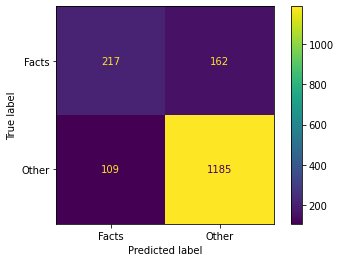

In [13]:
%%time
evaluate_with_test_set(default_mlp_trainer)

#### Linear SVM

In [14]:
from sklearn.svm import LinearSVC

def svm_trainer(X, y):
  svm = LinearSVC(random_state=1)
  return svm.fit(X, y)

In [15]:
%%time
cross_validation(svm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7599 0.0062 	 test: 0.5674 0.0833
Mean recall - std deviation    => train: 0.5668 0.0234 	 test: 0.4181 0.0985
Mean f1 - std deviation        => train: 0.6490 0.0139 	 test: 0.4676 0.0521
CPU times: user 5.25 s, sys: 649 ms, total: 5.9 s
Wall time: 5.18 s


### Evaluation with the test set ###
Precision: 0.7396
Recall:    0.5172
F-score:   0.6087
CPU times: user 1.21 s, sys: 115 ms, total: 1.33 s
Wall time: 1.2 s


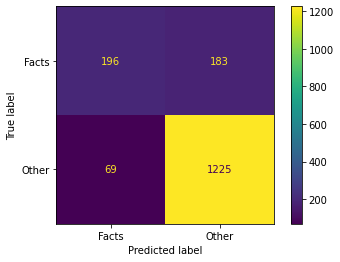

In [16]:
%%time
evaluate_with_test_set(svm_trainer)

#### RBF SVM

In [17]:
from sklearn.svm import SVC

def rbfsvm_trainer(X, y):
  rbfsvm = SVC(kernel='rbf', random_state=1)
  return rbfsvm.fit(X, y)

In [18]:
%%time

cross_validation(rbfsvm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9194 0.0096 	 test: 0.6267 0.1010
Mean recall - std deviation    => train: 0.7128 0.0260 	 test: 0.3814 0.0878
Mean f1 - std deviation        => train: 0.8026 0.0135 	 test: 0.4600 0.0517
CPU times: user 2min 41s, sys: 287 ms, total: 2min 41s
Wall time: 2min 40s


### Evaluation with the test set ###
Precision: 0.7510
Recall:    0.5172
F-score:   0.6125
CPU times: user 35.3 s, sys: 131 ms, total: 35.4 s
Wall time: 39.3 s


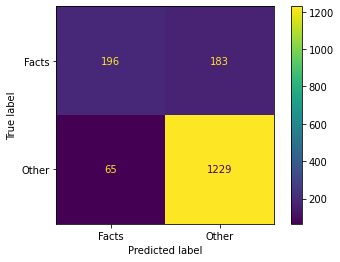

In [19]:
%%time

evaluate_with_test_set(rbfsvm_trainer)

#### Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

def lr_trainer(X, y):
  logreg = LogisticRegression(solver='sag', max_iter=200, random_state=1)
  return logreg.fit(X, y)

In [21]:
%%time

cross_validation(lr_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7359 0.0103 	 test: 0.6170 0.0849
Mean recall - std deviation    => train: 0.4626 0.0228 	 test: 0.3609 0.0856
Mean f1 - std deviation        => train: 0.5678 0.0185 	 test: 0.4413 0.0514
CPU times: user 9.48 s, sys: 604 ms, total: 10.1 s
Wall time: 9.6 s


### Evaluation with the test set ###
Precision: 0.7361
Recall:    0.5224
F-score:   0.6111
CPU times: user 1.94 s, sys: 103 ms, total: 2.04 s
Wall time: 1.92 s


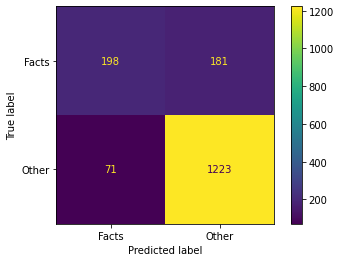

In [22]:
%%time

evaluate_with_test_set(lr_trainer)

#### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

def knn_trainer(X, y):
  knn = KNeighborsClassifier(5)
  return knn.fit(X, y)

In [24]:
%%time

cross_validation(knn_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8092 0.0040 	 test: 0.4714 0.0770
Mean recall - std deviation    => train: 0.6718 0.0124 	 test: 0.3765 0.0728
Mean f1 - std deviation        => train: 0.7341 0.0080 	 test: 0.4081 0.0336
CPU times: user 31.1 s, sys: 3.94 s, total: 35 s
Wall time: 21 s


### Evaluation with the test set ###
Precision: 0.5847
Recall:    0.4828
F-score:   0.5289
CPU times: user 1.92 s, sys: 272 ms, total: 2.19 s
Wall time: 1.26 s


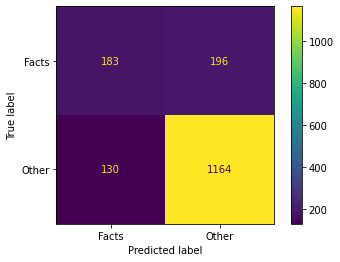

In [25]:
%%time

evaluate_with_test_set(knn_trainer)

#### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_trainer(X, y):
  dtree = DecisionTreeClassifier(random_state=1)
  return dtree.fit(X, y)

In [27]:
%%time

cross_validation(decision_tree_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9979 0.0010 	 test: 0.3595 0.0879
Mean recall - std deviation    => train: 0.9965 0.0010 	 test: 0.3789 0.0192
Mean f1 - std deviation        => train: 0.9972 0.0006 	 test: 0.3621 0.0410
CPU times: user 1min 4s, sys: 80.3 ms, total: 1min 4s
Wall time: 1min 4s


### Evaluation with the test set ###
Precision: 0.3814
Recall:    0.4116
F-score:   0.3959


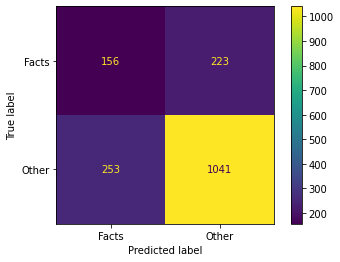

In [28]:
evaluate_with_test_set(decision_tree_trainer)

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_trainer(X, y):
  rforest = RandomForestClassifier(random_state=1)
  return rforest.fit(X, y)

In [30]:
cross_validation(random_forest_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9996 0.0005 	 test: 0.6534 0.1147
Mean recall - std deviation    => train: 0.9946 0.0011 	 test: 0.0995 0.0402
Mean f1 - std deviation        => train: 0.9971 0.0005 	 test: 0.1671 0.0599


### Evaluation with the test set ###
Precision: 0.9028
Recall:    0.1715
F-score:   0.2882


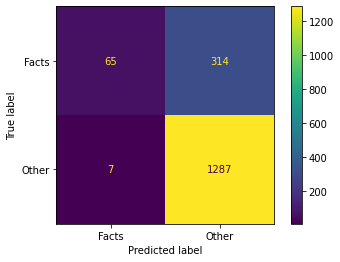

In [31]:
evaluate_with_test_set(random_forest_trainer)

#### AdaBoost

In [32]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_trainer(X, y):
  adab = AdaBoostClassifier(random_state=1)
  return adab.fit(X, y)

In [33]:
cross_validation(adaboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.6494 0.0157 	 test: 0.4963 0.0830
Mean recall - std deviation    => train: 0.4804 0.0259 	 test: 0.3494 0.0702
Mean f1 - std deviation        => train: 0.5520 0.0214 	 test: 0.4014 0.0472


### Evaluation with the test set ###
Precision: 0.6296
Recall:    0.4485
F-score:   0.5239


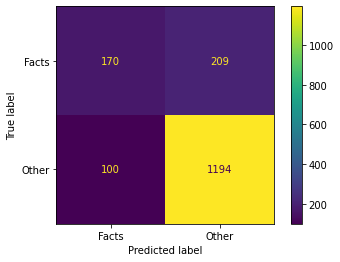

In [34]:
evaluate_with_test_set(adaboost_trainer)

#### Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_trainer(X, y):
  nb = GaussianNB()
  return nb.fit(X, y)


In [36]:
cross_validation(naive_bayes_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.4701 0.0195 	 test: 0.4321 0.0629
Mean recall - std deviation    => train: 0.7281 0.0095 	 test: 0.6782 0.0685
Mean f1 - std deviation        => train: 0.5710 0.0128 	 test: 0.5229 0.0433


### Evaluation with the test set ###
Precision: 0.5749
Recall:    0.8100
F-score:   0.6725


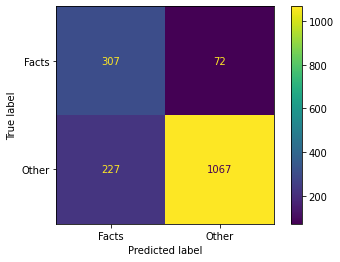

In [37]:
evaluate_with_test_set(naive_bayes_trainer)

#### XGBoost

In [38]:
from xgboost.sklearn import XGBClassifier
import torch

def xgboost_trainer(X, y):
  if torch.cuda.is_available():
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0)
  else:
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='hist')
  return xgboost.fit(X, y)


In [39]:
cross_validation(xgboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8937 0.0107 	 test: 0.5968 0.0776
Mean recall - std deviation    => train: 0.5559 0.0286 	 test: 0.2829 0.0682
Mean f1 - std deviation        => train: 0.6848 0.0190 	 test: 0.3750 0.0557


### Evaluation with the test set ###
Precision: 0.7969
Recall:    0.4037
F-score:   0.5359


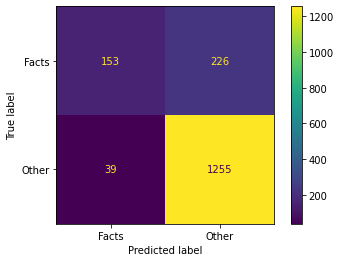

In [40]:
evaluate_with_test_set(xgboost_trainer)

### Results

In [41]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
for model_name, metrics in test_metrics.items():
  metrics_df.loc[model_name] = [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Precision,Recall,F1
MLPClassifier,0.6656,0.5726,0.6156
LinearSVC,0.7396,0.5172,0.6087
SVC,0.7510,0.5172,0.6125
LogisticRegression,0.7361,0.5224,0.6111
KNeighborsClassifier,0.5847,0.4828,0.5289
DecisionTreeClassifier,0.3814,0.4116,0.3959
RandomForestClassifier,0.9028,0.1715,0.2882
AdaBoostClassifier,0.6296,0.4485,0.5239
GaussianNB,0.5749,0.8100,0.6725
XGBClassifier,0.7969,0.4037,0.5359


### Reference paper:

> Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

